# Character based text Generation

#### Tell colab what version to use

In [1]:
%tensorflow_version 2.x

## Import standard Libraries

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import Model

# Load data

Convert to string

In [3]:
shakespeare = tfds.load('tiny_shakespeare')['train']
shakespeare = next(iter(shakespeare))
shakespeare = shakespeare['text'].numpy().decode('utf-8')
print(shakespeare[:100])

Shuffling and writing examples to /root/tensorflow_datasets/tiny_shakespeare/1.0.0.incompleteUK6K04/tiny_shakespeare-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/tiny_shakespeare/1.0.0.incompleteUK6K04/tiny_shakespeare-validation.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/tiny_shakespeare/1.0.0.incompleteUK6K04/tiny_shakespeare-test.tfrecord


Dataset tiny_shakespeare downloaded and prepared to /root/tensorflow_datasets/tiny_shakespeare/1.0.0. Subsequent calls will reuse this data.
First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


# Prepare the dataset

We can use python dictonaries to convert our chars to IDs or we use keras' StringLookup layer.
Using the StringLookup layer is more convenient, because we don't have to convert back and forth between tensors and numpy arrays to loop through.  
But the StringLookup layer also adds two additional vocabolary entries (' ', and '[UNK]') that we have to be aware of when translating predicted IDs back to text, as we don't want to sample those entries.

## Using dictionaries

In [24]:
# Function to get a string out of a tensor with char IDs
def text_from_ids(id_tensor):
    return ''.join([id2char[char] for char in id_tensor.numpy().flatten()])

In [25]:
# Create vocabulary
vocab = set(shakespeare)

# Use dictionaries to translate characters to IDs and back
char2id = {char:id for id, char in enumerate(vocab)}
id2char = {id:char for char,id in char2id.items()}

# Translate the shakespeare text to IDs
text_ids = [char2id[char] for char in shakespeare]

# Test 
print(text_ids[:20])

[21, 19, 7, 59, 31, 22, 57, 19, 31, 19, 60, 36, 53, 64, 48, 28, 36, 62, 6, 7]


### Create the sequences

In [26]:
SEQ_LEN = 20 #@param ["20", "50", "100"] {type:"raw"}

# Create dataset of sequences
ids_dataset = tf.data.Dataset.from_tensor_slices(text_ids)
# 'drop_remainder' drops the last batch if it's smaller than batch_size
seq_dataset = ids_dataset.batch(batch_size=SEQ_LEN+1, 
                                drop_remainder=True)

# Look at first sequence
for seq in seq_dataset.take(1):
    print(text_from_ids(seq))

First Citizen:
Before


### Create dataset of (input, target)-pairs

In [27]:
BATCH_SIZE = 64 #@param ["32", "64", "128"] {type:"raw"}
BUFFER_SIZE = 1000 #@param ["1000", "10000", "100000"] {type:"raw"}

# Create Datasets and make sure minibatches all have same size
dataset = seq_dataset.map(lambda seq: (seq[:-1],seq[1:]),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle the data
dataset = dataset.shuffle(BUFFER_SIZE)

# Create minibatches
dataset = dataset.batch(BATCH_SIZE,drop_remainder=True)

# Prefetch the data
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

dataset

<PrefetchDataset shapes: ((64, 20), (64, 20)), types: (tf.int32, tf.int32)>

## Using StringLookup (optional when not using dictionaries)

In [ ]:
# Function to get a string out of a tensor with char IDs
def text_from_ids_StringLookup(id_tensor):
    return tf.strings.reduce_join(id2char(id_tensor)).numpy().decode('utf-8')

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

# Create a tensor containing the text as a list of characters
text_tensor = tf.strings.unicode_split(shakespeare, 'UTF-8')

# Use the StringLookup layer to translate characters to IDs and back
char2id = StringLookup(vocabulary=list(set(shakespeare)))
id2char = StringLookup(vocabulary=char2id.get_vocabulary(), invert=True)

# Create vocabulary (use the StringLookup vocabulary because that contains padding and unknown characters at indeces '0' and '1')
vocab = char2id.get_vocabulary()

# Translate the shakespeare text to IDs
text_ids = char2id(text_tensor)

# Test 
print(text_ids)

tf.Tensor([42 65 38 ... 18 38 18], shape=(1003854,), dtype=int64)


### Create the sequences (StringLookup)

In [ ]:
SEQ_LEN = 20 #@param ["20", "50", "100"] {type:"raw"}

# Create dataset of sequences
ids_dataset = tf.data.Dataset.from_tensor_slices(text_ids)
# 'drop_remainder' drops the last batch if it's smaller than batch_size
seq_dataset = ids_dataset.batch(batch_size=SEQ_LEN+1, 
                                drop_remainder=True)

# Look at first sequence
for seq in seq_dataset.take(1):
    print(text_from_ids_StringLookup(seq))

First Citizen:
Before


### Create dataset of (input, target)-pairs (StringLookup)

In [ ]:
BATCH_SIZE = 64 #@param ["32", "64", "128"] {type:"raw"}
BUFFER_SIZE = 1000 #@param ["1000", "10000", "100000"] {type:"raw"}

# Create Datasets and make sure minibatches all have same size
dataset_StringLookup = seq_dataset.map(lambda seq: (seq[:-1],seq[1:]),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle the data
dataset_StringLookup = dataset_StringLookup.shuffle(BUFFER_SIZE)

# Create minibatches
dataset_StringLookup = dataset_StringLookup.batch(BATCH_SIZE,drop_remainder=True)

# Prefetch the data
dataset_StringLookup = dataset_StringLookup.prefetch(tf.data.experimental.AUTOTUNE)

dataset_StringLookup

<PrefetchDataset shapes: ((64, 20), (64, 20)), types: (tf.int64, tf.int64)>

# Inspect the dataset

In [29]:
for input, target in dataset.take(1):
    print(f'Input-target pair:\n{input[0], target[0]}')
    print(f'\nInput:  {text_from_ids(input[0])}\nTarget:  {text_from_ids(target[0])}')

Input-target pair:
(<tf.Tensor: shape=(20,), dtype=int32, numpy=
array([ 6, 22, 49,  6, 50, 36, 59, 22, 12, 36,  7, 36, 41, 48, 48, 26, 36,
       49,  6, 53], dtype=int32)>, <tf.Tensor: shape=(20,), dtype=int32, numpy=
array([22, 49,  6, 50, 36, 59, 22, 12, 36,  7, 36, 41, 48, 48, 26, 36, 49,
        6, 53, 13], dtype=int32)>)

Input:  o comes here?

Secon
Target:   comes here?

Second


# Define RNN cell

We define our weight matrizes as simple dense layers without activation.  
It's important to not use a bias in the input layer.

In [30]:
class RNN_cell(Model):
    def __init__(self, state_size):
        super(RNN_cell, self).__init__()
        # W_xh
        self.input_weights = tf.keras.layers.Dense(units=state_size,
                                                   activation=None,
                                                   use_bias = False,
                                                   name='Input_layer'
                                                   )
        # W_hh+b_h
        self.hidden_weights = tf.keras.layers.Dense(units=state_size,
                                                    activation=None,
                                                    name='Hidden_layer'
                                                    )
        
    def call(self, x_t, h_t):
        # Computing the new hidden state
        if h_t == None:
            h_t = tf.keras.activations.relu(self.input_weights(x_t))
        else:
            # h_t = activation(x_t*W_xh + h_t*W_hh+b_h)
            h_t = tf.keras.activations.relu(self.input_weights(x_t)+self.hidden_weights(h_t))        
        return h_t

## Inspect RNN cell

In [31]:
cell = RNN_cell(128)
_ = cell(tf.ones((BATCH_SIZE,64)),
         tf.zeros((BATCH_SIZE,128))
        )
cell.summary()

Model: "rnn_cell_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (Dense)          multiple                  8192      
_________________________________________________________________
Hidden_layer (Dense)         multiple                  16512     
Total params: 24,704
Trainable params: 24,704
Non-trainable params: 0
_________________________________________________________________


# Define RNN

In [32]:
class RNN(Model):
    def __init__(self, state_size, vocab_size, embedding_size):
        super(RNN, self).__init__()
        self.state_size = state_size

        self.readin_layer = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                      output_dim=embedding_size,
                                                      input_length=SEQ_LEN,
                                                      name='ReadIn_layer'
                                                      )
        
        self.RNNcell = RNN_cell(self.state_size)

        self.output_layer = tf.keras.layers.Dense(units=vocab_size,
                                                  activation='softmax',
                                                  name='Readout_layer'
                                                 )
          
    def call(self, seq):
        t = tf.constant(0)
        # Store the outputs of each timestep in a TensorArray
        outputs = tf.TensorArray(tf.float32, size=SEQ_LEN)

        seq = self.readin_layer(seq)

        # First timestep; reset hidden state
        h_t = None

        h_t = self.RNNcell(seq[:,t], h_t)

        output = self.output_layer(h_t)
        outputs = outputs.write(0,output)
        t += 1
        
        # Use tensorflow conditional tf.less for graph mode
        while tf.less(t, SEQ_LEN):
            h_t = self.RNNcell(seq[:,t], h_t)
            output = self.output_layer(h_t)
            outputs = outputs.write(t,output)
            t += 1
        
        # Transpose the TensorArray to get shape (BATCH_SIZE, Timesteps, output_size)
        rnn_out = tf.transpose(outputs.stack(),perm=[1,0,2])
        return rnn_out

## Inspect RNN

We sample one character for each timestep using the softmax output as distribution.

In [53]:
rnn = RNN(4096, len(vocab), 256)
for input, target in dataset.take(1):
    rnn_out = rnn(input)
    print(f'Input: {text_from_ids(input[0])}\n')
    predicted_ids = tf.random.categorical(tf.math.log(rnn_out[0]), num_samples=1)
    print(f'Prediction: {text_from_ids(predicted_ids)}\n')

rnn.summary()

Input: is good belly,
And y

Prediction: LhD!pJQnHs! hp-y,Y-Y

Model: "rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ReadIn_layer (Embedding)     multiple                  16640     
_________________________________________________________________
rnn_cell (RNN_cell)          multiple                  17829888  
_________________________________________________________________
Readout_layer (Dense)        multiple                  266305    
Total params: 18,112,833
Trainable params: 18,112,833
Non-trainable params: 0
_________________________________________________________________


# Define LSTM

In [34]:
class LSTM_cell(Model):
    def __init__(self, unit_size):
        super(LSTM_cell, self).__init__()
        self.forget_gate = tf.keras.layers.Dense(units=unit_size,
                                                 activation='sigmoid',
                                                 bias_initializer='ones',
                                                 name='Forget_gate'
                                                )
        
        self.input_gate = tf.keras.layers.Dense(units=unit_size,
                                                activation='sigmoid',
                                                name='Input_gate'
                                               )
        
        self.candidates = tf.keras.layers.Dense(units=unit_size,
                                                activation='tanh',
                                                name='Candidate_layer'
                                                )
        
        self.output_gate = tf.keras.layers.Dense(units=unit_size,
                                                 activation='sigmoid',
                                                 name='Output_gate'
                                                )
    
    def call(self, x_t, states):
        h_t, c_t = states
        cell_input = tf.concat((x_t,h_t),1)

        # Computing the filter
        f_t = self.forget_gate(cell_input)
        i_t = self.input_gate(cell_input)
        candidates = self.candidates(cell_input)
        o_t = self.output_gate(cell_input)
        
        # Computing the new states
        c_t = f_t*c_t + i_t*candidates            
        h_t = o_t*tf.nn.tanh(c_t)
        
        return (h_t,c_t)

In [51]:
class LSTM(Model):
    def __init__(self, state_size, vocab_size, embedding_size):
        super(LSTM, self).__init__()
        self.state_size = state_size

        self.readin_layer = tf.keras.layers.Embedding(input_dim=vocab_size,
                                                      output_dim=embedding_size,
                                                      input_length=SEQ_LEN,
                                                      name='ReadIn_layer'
                                                      )
        
        self.LSTMcell = LSTM_cell(self.state_size)

        self.output_layer = tf.keras.layers.Dense(units=vocab_size,
                                                  activation='softmax',
                                                  name='Readout_layer'
                                                 )
          
    def call(self, seq):
        t = tf.constant(0)
        # Store the outputs of each timestep in a TensorArray
        outputs = tf.TensorArray(tf.float32, size=SEQ_LEN)

        seq = self.readin_layer(seq)


        # First timestep; reset hidden state
        h_t = tf.zeros((tf.shape(seq)[0],self.state_size))
        c_t = tf.zeros((tf.shape(seq)[0],self.state_size))

        h_t, c_t = self.LSTMcell(seq[:,t,:],
                                 (h_t,c_t))

        output = self.output_layer(h_t)
        outputs = outputs.write(0,output)
        t += 1
        
        # Use tensorflow conditional tf.less for graph mode
        while tf.less(t, SEQ_LEN):
            h_t, c_t = self.LSTMcell(seq[:,t,:],(h_t,c_t))

            output = self.output_layer(h_t)
            outputs = outputs.write(t,output)
            t += 1
        
        # Transpose the TensorArray to get shape (BATCH_SIZE, Timesteps, output_size)
        rnn_out = tf.transpose(outputs.stack(),perm=[1,0,2])
        return rnn_out

In [52]:
lstm = LSTM(2048, len(vocab), 256)
for input, target in dataset.take(1):
    lstm_out = lstm(input)
    print(f'Input: {text_from_ids(input[0])}\n')
    predicted_ids = tf.random.categorical(tf.math.log(lstm_out[0]), num_samples=1)
    print(f'Prediction: {text_from_ids(predicted_ids)}\n')

lstm.summary()

Input: an 't please
you, de

Prediction: BxQ!sCU zswFnSrR$VSY

Model: "lstm_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ReadIn_layer (Embedding)     multiple                  16640     
_________________________________________________________________
lstm_cell_3 (LSTM_cell)      multiple                  18882560  
_________________________________________________________________
Readout_layer (Dense)        multiple                  133185    
Total params: 19,032,385
Trainable params: 19,032,385
Non-trainable params: 0
_________________________________________________________________


# Define the training process

#### Function to plot the models performance

In [37]:
from IPython.display import clear_output

def visualize_progress(num_epochs, epoch, train_losses):
    clear_output(wait=True)
    fig = plt.figure(figsize=(15,5))
    plt.xlim((0,num_epochs))
    plt.plot(train_losses,label='Training')
    plt.ylabel('Loss',fontsize=24)
    plt.xlabel('Epochs',fontsize=24)
    plt.title(f'Epoch: {epoch+1}', fontweight='bold', fontsize=30)
    plt.xticks(np.arange(0,num_epochs,2))
    plt.legend()
    plt.show() 

In [38]:
def train_model(model, dataset, loss_function, optimizer, num_epochs):
    running_average_factor = 0.95

    # Initialize lists for later visualization.
    train_losses = []
    
    # Train loop for num_epochs epochs.
    for epoch in range(num_epochs):
            
        # Training
        running_average_loss = 0
        for input_seq, target_seq in dataset:
            train_loss = train_step(model, input_seq, target_seq, loss_function, optimizer)
            running_average_loss = running_average_factor * running_average_loss  + (1 - running_average_factor) * train_loss

        train_losses.append(running_average_loss.numpy())

        visualize_progress(num_epochs, epoch, train_losses)

        # Look at one sequence and it's prediction
        for input_seq, target_seq in dataset.take(1):
            pred = model(input_seq)
            print(f'Input: {text_from_ids(input_seq[0])}\n')
            predicted_ids = tf.random.categorical(tf.math.log(pred[0]), num_samples=1)
            print(f'Prediction: {text_from_ids(predicted_ids)}\n')
            
        # Display loss and accuracy for current epoch    
        print(f'Epoch: __ {epoch+1}')
        print('Train loss: ',running_average_loss.numpy())

# Define training

In [39]:
@tf.function
def train_step(model, input_seq, target_seq, loss_function, optimizer):
    with tf.GradientTape() as tape:
        pred = model(input_seq)
        loss = loss_function(target_seq, pred)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

# Train RNN

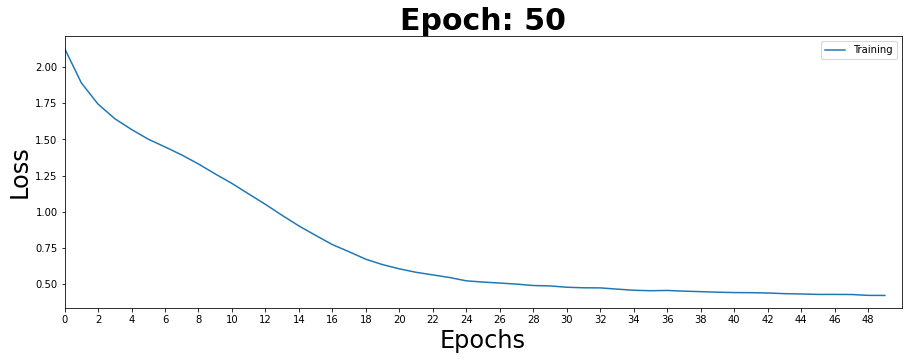

Input: tizen:
Well, sir, wh

Prediction:  cen:
Yell, sir, wha

Epoch: __ 50
Train loss:  0.42283934
CPU times: user 27min 22s, sys: 3min 50s, total: 31min 12s
Wall time: 1h 29min 19s


In [40]:
%%time
tf.keras.backend.clear_session()

learning_rate = 0.0001
state_size = 4096
embedding_size = 256
epochs = 50

# Initialize the loss
# We use SparseCategoricalCrossentropy here
# This way we don't have to onehot encode our targets and can just use the charID and the softmax prediction to calculate the loss
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize model
rnn = RNN(state_size, len(vocab), embedding_size)
train_model(
    model = rnn,
    dataset = dataset,
    num_epochs = epochs,
    loss_function = loss_function,
    optimizer = optimizer
)

In [41]:
rnn.summary()

Model: "rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ReadIn_layer (Embedding)     multiple                  16640     
_________________________________________________________________
rnn_cell (RNN_cell)          multiple                  17829888  
_________________________________________________________________
Readout_layer (Dense)        multiple                  266305    
Total params: 18,112,833
Trainable params: 18,112,833
Non-trainable params: 0
_________________________________________________________________


# Create Text

In [43]:
def generate_text(in_seq, length=1000):
    input_ids = np.array([char2id[char] for char in in_seq])    

    output_text = in_seq
    states=None

    for _ in range(length):
        input_id_tensor = tf.convert_to_tensor(input_ids)
        # Add batch dimension
        input_id_tensor = tf.expand_dims(input_ids,0)

        rnn_out = rnn(input_id_tensor)
        predicted_ids = tf.random.categorical(tf.math.log(rnn_out[0]), num_samples=1)
        input_ids = np.delete(input_ids,0)
        input_ids = np.append(input_ids, tf.squeeze(predicted_ids).numpy()[-1])
        output_text += text_from_ids(predicted_ids)[-1]

    print(output_text)

generate_text('What do you think of')

What do you think of Hostandies.
Raisin way the deligsted then with honest was friend him Rome, but knows he had be all, to a goos light!

BUCKININES:
You know the steal neter, elver. A perpatate, and to see this instane a
didones for the
evords: see wherefore? abe the grave a will; but keep woust my father's slave,
and ghen with her, Master Earl of sir, repare than o'er the chorestisen's foolshapes her by had sobotite words.

ANFILO:
You are a thousand souls,
why, old be grandous lord ribhous to the way be valient end against him:
He im gorates i' Keepicy,
What since ' thank you. At that possessice
Shall straight deal downrnal and by have to'en you hear dose seen a dozence; if I dangly teath,
Where's Pagains what 'lave? way for a halffal larr's custom.

ISABELLA:
O, will you me so fured,
Bit gull be no so, sir; that you might profess sonce.
Bet one on her. That Appry and unant at.

DUKE VINCENTIO:
Sir, in my poor brother's life:-live, no anmighous to gue be woo: and left,
Master Liee 

# Train LSTM

After seeing the results we decided to also use our LSTM from the last homework.

In [56]:
@tf.function
def train_step(model, input_seq, target_seq, loss_function, optimizer):
    with tf.GradientTape() as tape:
        pred = model(input_seq)
        loss = loss_function(target_seq, pred)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

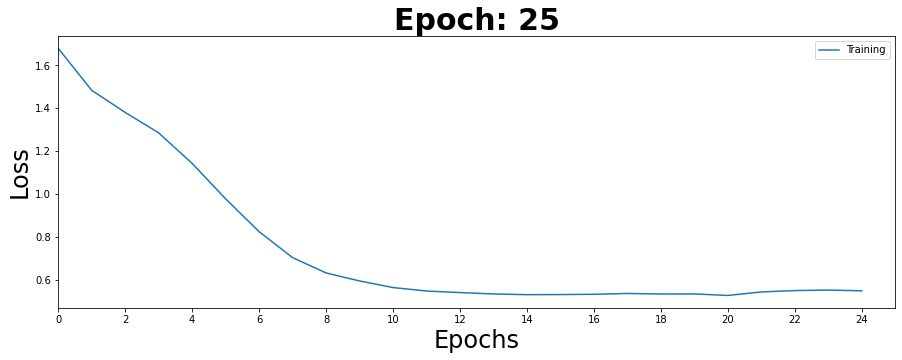

Input: ncorporate friends,'

Prediction: datporate fliend,,' 

Epoch: __ 25
Train loss:  0.548664
CPU times: user 31min 30s, sys: 4min 42s, total: 36min 12s
Wall time: 2h 56min 7s


In [57]:
%%time
tf.keras.backend.clear_session()

learning_rate = 0.001
state_size = 4096
embedding_size = 256
epochs = 25

# Initialize the loss
# We use SparseCategoricalCrossentropy here
# This way we don't have to onehot encode our targets and can just use the charID and the softmax prediction to calculate the loss
loss_function = tf.keras.losses.SparseCategoricalCrossentropy()

# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize model
lstm = LSTM(state_size, len(vocab), embedding_size)
train_model(
    model = lstm,
    dataset = dataset,
    num_epochs = epochs,
    loss_function = loss_function,
    optimizer = optimizer
)

In [58]:
lstm.summary()

Model: "lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ReadIn_layer (Embedding)     multiple                  16640     
_________________________________________________________________
lstm_cell (LSTM_cell)        multiple                  71319552  
_________________________________________________________________
Readout_layer (Dense)        multiple                  266305    
Total params: 71,602,497
Trainable params: 71,602,497
Non-trainable params: 0
_________________________________________________________________


# Create Text

In [60]:
def generate_text(in_seq, length=1000):
    input_ids = np.array([char2id[char] for char in in_seq])    

    output_text = in_seq
    states=None

    for _ in range(length):
        input_id_tensor = tf.convert_to_tensor(input_ids)
        # Add batch dimension
        input_id_tensor = tf.expand_dims(input_ids,0)

        lstm_out = lstm(input_id_tensor)
        predicted_ids = tf.random.categorical(tf.math.log(lstm_out[0]), num_samples=1)
        input_ids = np.delete(input_ids,0)
        input_ids = np.append(input_ids, tf.squeeze(predicted_ids).numpy()[-1])
        output_text += text_from_ids(predicted_ids)[-1]

    print(output_text)

generate_text('What do you think of')

What do you think of stags,
As to a feel dwell inmedits to melanchy, breach in heavier what his bind stand I ben content yourselves? I do advant you, this is your honour will continue to instruct him, our mother's, I will go all so frames
As office as the view that kise my meeds,
which yet hath forsome forfeit oncl;
And I thank thee thus high strange,
And I should kind my husband;
And of his office, with surery and as he,
sick for them now, nay not you?

RICHORD:
Gremio?

GREMIO:
What's he?

Proviste
Is fill my father,'s singly, savour'st to my soul: now are well upond
These two affictless remutation of this peace and gracious for
,rements, but I emper ye were here!
Thy fortunes is my brother's life and leave at me, the people you shall perceive;
Scome his honour than he
Dare mine arms about him, for I knew no shame on her,
As he is a come that now in place and less! Then
let me have you no?

GRUMIO:
Well, sir.

SICINIUS:
Let me see them is amazento traitors! 'Twas your fault, I know h